# **Moodyfy: Sistem Rekomendasi Musik Berbasis Mood & Pola Audio**

**Deskripsi Projek:**
Projek ini bertujuan untuk membangun sistem rekomendasi musik melalui pendekatan berbasis Machine Learning. Sistem ini mengidentifikasi mood dari lagu menggunakan klasifikasi, mengelompokkan lagu berdasarkan karakteristik audio, dan memberikan rekomendasi lagu yang serupa.

**Metodologi:**
1.  **Klasifikasi Mood (Supervised):** Menggunakan *Random Forest* untuk memprediksi mood (Happy, Sad, Calm, Energetic) pada dataset lagu yang belum berlabel.
2.  **Klastering Pola (Unsupervised):** Menggunakan *K-Means Clustering* untuk mengelompokkan lagu berdasarkan fitur audio.
3.  **Sistem Rekomendasi:** Menggunakan *K-Nearest Neighbors (KNN)* untuk mencari kemiripan lagu (*similarity search*).

**Dataset:**
- `data_moods.csv`: Data latih dengan label mood.
- `data.csv`: Data lagu Spotify umum (unlabeled).

# **1. Import Library**
Mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [ ]:
import pandas as pd
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

## **2. Memuat Dataset**

Pada tahap ini berfokus pada pemuatan dataset ke dalam notebook lalu mengecek informasi dataset sebelum nantinya dilakukan pembersihan.

**Fokus Analisis:**
   - Memuat dataset ke dalam notebook dan menampilkan 5 baris pertama.

In [ ]:
# Load data dengan label mood dan menampilkan 5 baris pertama.
df_labeled = pd.read_csv('data_moods.csv')
df_labeled.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


In [ ]:
# Load data dengan lagu tanpa label dan menampilkan 5 baris pertama.
df_unlabeled = pd.read_csv('data.csv')
df_unlabeled.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


## **3. Exploratory Data Analysis (EDA): Visualisasi Fitur Audio**

Tahap ini bertujuan untuk memahami karakteristik statistik dari fitur audio dan bagaimana fitur-fitur tersebut berinteraksi satu sama lain.

**Fokus Analisis:**
* **Analisis Korelasi (Heatmap):** Mengidentifikasi hubungan linear antar fitur (misalnya, hubungan positif antara *Energy* dan *Loudness*).

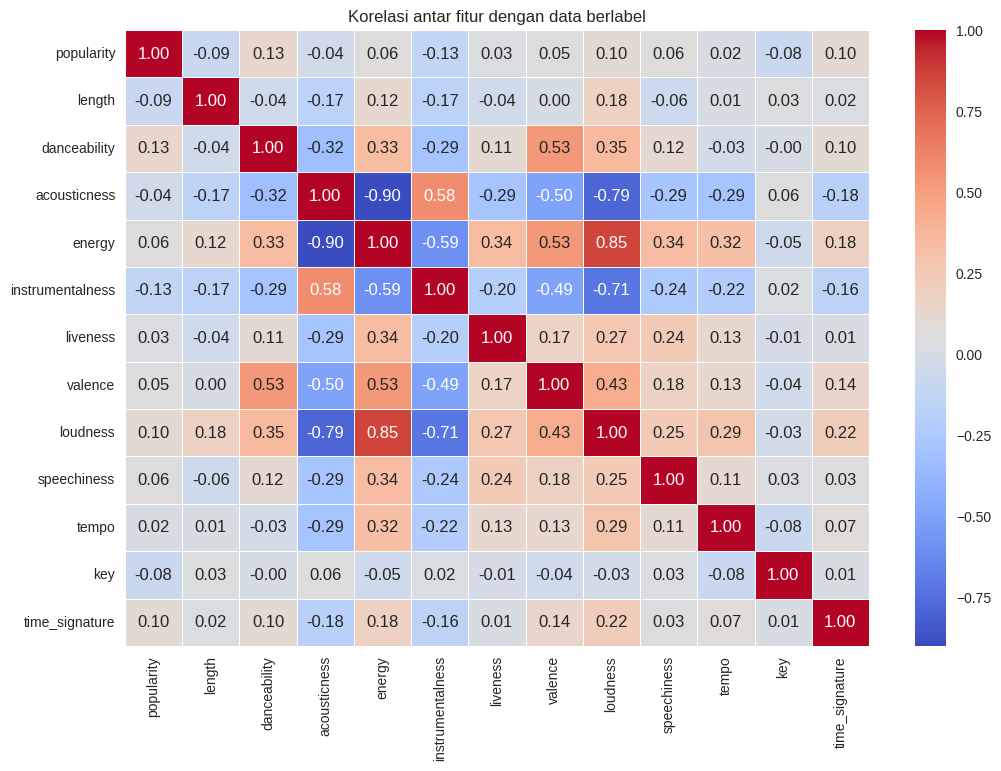

In [ ]:
# Tabel heatmap korelasi antar fitur
plt.figure(figsize=(12, 8))
sns.heatmap(df_labeled.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Korelasi antar fitur dengan data berlabel")
plt.show()

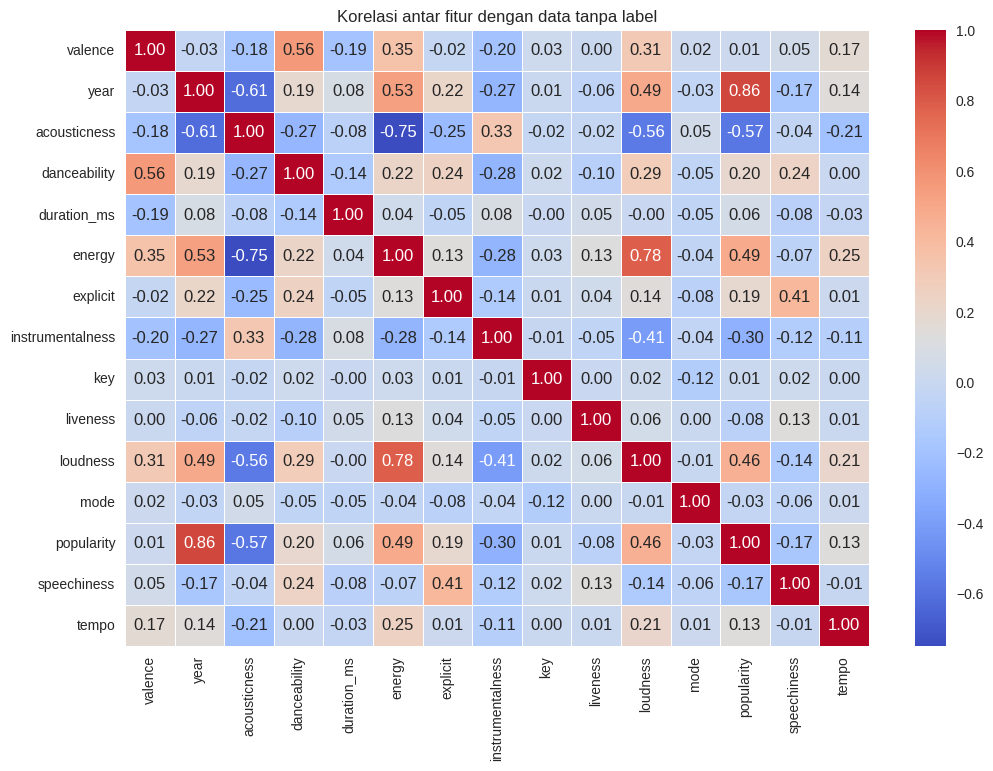

In [ ]:
# Tabel heatmap korelasi antar fitur
plt.figure(figsize=(12, 8))
sns.heatmap(df_unlabeled.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Korelasi antar fitur dengan data tanpa label")
plt.show()

## **4. Pembersihan dan Pra Pemrosesan Data**

Tahap ini bertujuan untuk pembersihan data, karena Machine Learning belajar dari data apa adanya, sehingga data yang kotor, tidak lengkap, atau tidak konsisten akan menyebabkan model menangkap pola yang salah dan menghasilkan prediksi yang tidak akurat.

**Fokus Analisis:**
* **Menghapus data dulpikat:** Menghapus lagu yang muncul berulang untuk mencegah bias pada distribusi fitur.
* **Pembersihan Nilai Kosong:** Menghapus atau menangani data yang tidak lengkap guna menjaga konsistensi vektor fitur audio.
* **Feature Selection:** Memilih fitur numeri pada audio agar menghasilkan hasil yang relevan.
* **Standarisasi (StandardScaler):** Menyamakan skala fitur ke dalam distribusi yang seragam agar tidak ada perbedaan rentang nilai yang sangat berbeda.

In [ ]:
# Menghapus duplikat data dengan fitur name dan artis
df_labeled = df_labeled.drop_duplicates(subset=['name', 'artist'], keep='first')
df_unlabeled = df_unlabeled.drop_duplicates(subset=['name', 'artists'], keep='first')

# Menghapus missing values (data kosong)
df_labeled = df_labeled.dropna()
df_unlabeled = df_unlabeled.dropna()

# Reset index agar index nya urut kembali (0, 1, 2...)
df_labeled = df_labeled.reset_index(drop=True)
df_unlabeled = df_unlabeled.reset_index(drop=True)

In [ ]:
# Fitur numerik untuk masalah pengelompokan
features = ['danceability', 'acousticness', 'energy', 'instrumentalness',
           'liveness', 'valence', 'loudness', 'speechiness', 'tempo']

In [ ]:
# Memisahkan fitur dan label untuk membagi data menjadi data latih 75% dan data uji 25%
X = df_labeled[features]
y = df_labeled['mood']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Standarisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **6. Model Training & Evaluation (Random Forest)**

Tahap ini mencakup pembangunan model untuk pelabelan otomatis.

**Fokus Analisis:**
* **Klasifikasi Mood:** Melatih model *Random Forest* untuk memprediksi mood pada dataset utama berdasarkan karakteristik audio yang telah dipelajari.
* **Performance Metrics:** Mengevaluasi akurasi klasifikasi melalui *Classification Report*.

In [ ]:
# Melatih model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Menghitung nilai precision, recall, F1 score, dan support
y_pred = rf_model.predict(X_test_scaled)
print("Classification Report (75:25) :")
print(classification_report(y_test, y_pred))

Classification Report (90:10) :
              precision    recall  f1-score   support

        Calm       0.92      0.98      0.95        46
   Energetic       0.69      0.74      0.72        39
       Happy       0.56      0.55      0.55        33
         Sad       0.92      0.83      0.87        54

    accuracy                           0.80       172
   macro avg       0.77      0.78      0.77       172
weighted avg       0.80      0.80      0.80       172



In [ ]:
# Melakukan ekstraksi fitur dan normalisasi data
X_unlabeled = df_unlabeled[features]
X_unlabeled_scaled = scaler.transform(X_unlabeled)

In [ ]:
# Melakukan prediksi mood menggunakan model Random Forest
predictions = rf_model.predict(X_unlabeled_scaled)

In [ ]:
# Menyimpan hasil prediksi ke dalam kolom baru 'mood'
df_unlabeled['mood'] = predictions

In [ ]:
# Menampilkan 5 baris pertama untuk verifikasi hasil
df_unlabeled.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,mood
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,Calm
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Sad
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,Calm
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Sad
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Sad


In [ ]:
# Mengukur pentingnya fitur pada model
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))


Feature Importance:
            feature  importance
3  instrumentalness    0.239391
2            energy    0.198729
6          loudness    0.155251
1      acousticness    0.139800
5           valence    0.071768
7       speechiness    0.061571
0      danceability    0.060782
8             tempo    0.039170
4          liveness    0.033537


In [ ]:
# Menyimpan hasil data training
df_unlabeled.to_csv('music_with_mood.csv', index=False)

## **7. Feature Engineering & Scaling**

Tahap ini bertujuan untuk mentransformasi fitur audio mentah menjadi format numerik yang terstandarisasi agar model dapat memberikan bobot pada setiap parameter.

**Fokus Analisis:**
* **Feature Selection:** Mengisolasi fitur-fitur audio spesifik yang memiliki pengaruh signifikan terhadap persepsi mood musik.
* **Standarisasi (StandardScaler):** Menyamakan skala fitur ke dalam distribusi yang seragam karena algoritma berbasis jarak (KNN & K-Means) sangat sensitif terhadap perbedaan rentang nilai.

In [ ]:
# Load data hasil training dan menampilkan 5 baris pertama.
df = pd.read_csv("music_with_mood.csv")
df = df.reset_index(drop=True)
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,mood
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,Calm
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Sad
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,Calm
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Sad
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Sad


In [ ]:
# Pilih fitur numerik untuk pengelompokan
numerical_features = [
    "valence", "danceability", "energy", "tempo",
    "acousticness", "liveness", "speechiness", "instrumentalness"
]

In [ ]:
# Standarisasi data
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[numerical_features]),
    columns=numerical_features
)

## **8. Membangun model K-Means Clustering**

Tahap ini mencakup pengelompokan pola lagu secara intrinsik.

**Fokus Analisis:**
* **Clustering:** Menggunakan K-Means untuk menemukan segmen lagu yang memiliki kemiripan suara secara otomatis tanpa bergantung pada label.
* **Performance:** Mengevaluasi kualitas cluster melalui Silhouette Score.
* **Visualisasi:** Melakukan visualisasi Elbow Method untuk menentukan jumlah cluster terbaik.

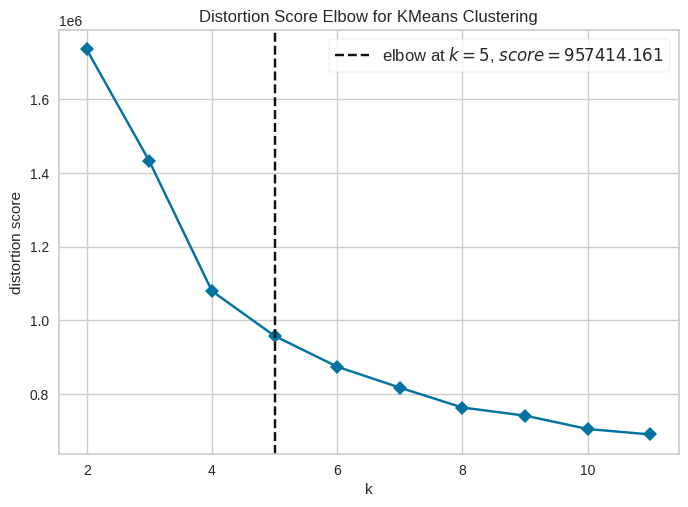

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Melakukan visualisasi Elbow Method menggunakan KElbowVisualizer()
model = KMeans(random_state=42)
elbow = KElbowVisualizer(model, k=(2, 12), metric='distortion', timings=False)
elbow.fit(X_unlabeled_scaled)

elbow.show()

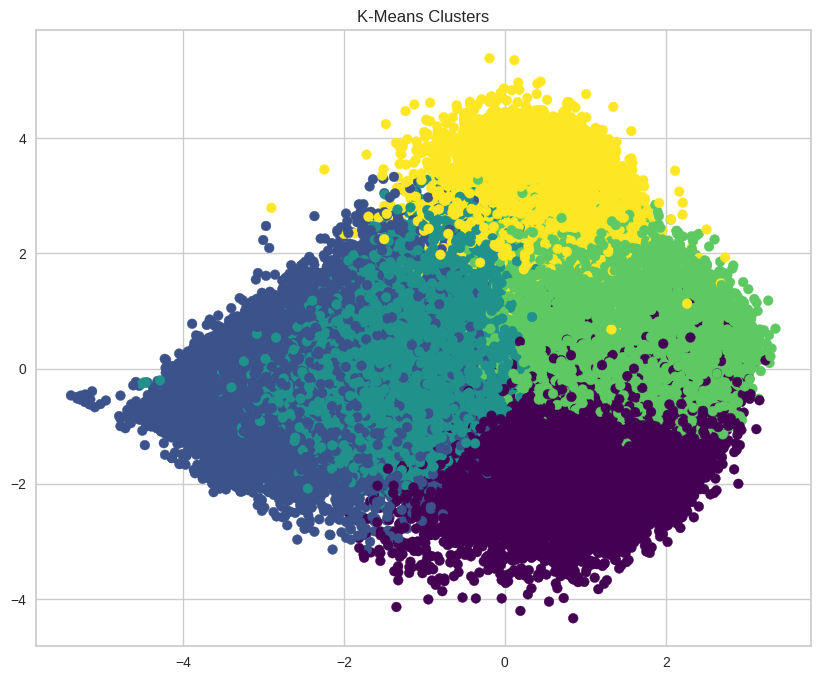

In [ ]:
# K-Means Clustering
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["Cluster"] = kmeans.fit_predict(df_scaled)

# Visualisasi kluster menggunakan PCA (Analisis Komponen Utama)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Plot kluster
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df["Cluster"], cmap="viridis")
plt.title("K-Means Clusters")
plt.show()

In [ ]:
# Silhouette score
score = silhouette_score(X_unlabeled_scaled, kmeans.labels_, metric='euclidean')
print(f"Silhouette Score untuk K-Means: {score:.4f}")

Silhouette Score untuk K-Means: 0.1502


In [ ]:
# Menyimpan hasil data clustering
df.to_csv("clustered_df.csv")

**9. Sistem rekomendasi menggunakan K-Nearest Neighbors (KNN)**

Tahap akhir ini mengintegrasikan seluruh komponen menjadi satu sistem pemberi rekomendasi lagu menggunakan prinsip pencarian tetangga terdekat.

**Fokus Analisis:**
* **KNN:** Menghitung jarak Euclidean antar lagu dalam ruang fitur untuk menemukan kemiripan maksimal.
* **Recommendation Logic:** Mengambil input lagu atau mood pengguna dan menyajikan daftar rekomendasi lagu yang paling mirip dengan input.

In [ ]:
# Inisialisasi model KNN (mencari 6 tetangga terdekat)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
model_knn.fit(X_unlabeled_scaled)

# Judul Lagu
judul = input("Masukkan judul lagu: ")

# Cari rekomendasi lagu
try:
    filter_lagu = df_unlabeled[df_unlabeled['name'].str.lower() == judul.lower()]
    idx = filter_lagu.index[0]

    # Cari 5 lagu terdekat menggunakan KNN
    distances, indices = model_knn.kneighbors(X_unlabeled_scaled[idx].reshape(1, -1))

    print(f"\nLagu ditemukan: {df_unlabeled.iloc[idx]['name']} - {df_unlabeled.iloc[idx]['artists']}")
    print("Berikut 5 rekomendasi lagu:")

    # Menampilkan 5 hasil rekomendasi (index 1 sampai 5)
    for i in range(1, 6):
        res_idx = indices.flatten()[i]
        print(f"- {df_unlabeled.iloc[res_idx]['name']} oleh {df_unlabeled.iloc[res_idx]['artists']}")

# error handling jika input salah atau tidak ada
except IndexError:
    print(f"Maaf lagu '{judul}' tidak ditemukan. sepertinya lagu belum tersedia di database dan pastikan judul sudah tepat")

Masukkan judul lagu: perfect

Lagu ditemukan: Perfect - ['One Direction']
Berikut 5 rekomendasi lagu:
- Finest Hour (feat. Abir) oleh ['Cash Cash', 'ABIR']
- PJ Masks Theme Song oleh ['PJ Masks']
- Just Like Candy oleh ['8Ball', 'MJG']
- Sound Of Change oleh ['Dirty Heads']
- One More Road To Cross oleh ['DMX']


In [ ]:
# Input mood dari user
mood_input = input("Gimana mood saat ini (Happy, Sad, Calm, Energetic): ").title()

# Filter lagu berdasarkan mood hasil prediksi Random Forest
mood_songs = df_unlabeled[df_unlabeled['mood'] == mood_input]

# Error handling jika input salah
if mood_songs.empty:
  print(f"Mood '{mood_input}' tidak ditemukan dalam dataset.")

# Pilih satu lagu secara acak dari mood untuk dijadikan acuan dalam pencarian KNN
chosen_song_sample = mood_songs.sample(n=1)
chosen_idx = chosen_song_sample.index[0]

print(f"\nBerdasarkan mood {mood_input}, kami gunakan lagu: '{df_unlabeled.loc[chosen_idx, 'name']}' sebagai dasar rekomendasi")

# Inisialisasi & Fit KNN
knn = NearestNeighbors(n_neighbors=21, metric='cosine')
knn.fit(X_unlabeled_scaled)

# Mencari tetangga terdekat dari lagu yang terpilih
distances, indices = knn.kneighbors(X_unlabeled_scaled[chosen_idx].reshape(1, -1))

# Mengambil index tetangga (abaikan index pertama karena itu lagu itu sendiri)
neighbors_indices = indices[0][1:]

# Mengambil 5 sampel acak dari tetangga tersebut
recommended_indices = random.sample(list(neighbors_indices), 5)
rec_songs = df_unlabeled.loc[recommended_indices, ['name', 'artists', 'mood']]

# Menampilkan rekomendasi lagu
print("\nBerikut 5 rekomendasi lagu:")
for _, row in rec_songs.iterrows():
  print(f"- {row['name']} oleh {row['artists']} (Mood: {row['mood']})")

Gimana mood saat ini (Happy, Sad, Calm, Energetic): sad

Berdasarkan mood Sad, kami gunakan lagu: 'Saqi Idhar Bhi Jaam' sebagai dasar rekomendasi

Berikut 5 rekomendasi lagu:
- Armaan Loot Gaye Hae oleh ['Shanta Kunwar'] (Mood: Sad)
- Ti exeis Rina kai arrostaineis oleh ['Georgia Mitaki', 'Giorgos Anestopoylos', 'Klarino'] (Mood: Sad)
- Karuna Kaastha oleh ['V. Ramakrishna'] (Mood: Sad)
- Llanto - Remasterizado oleh ['Francisco Canaro', 'Ernesto Fama'] (Mood: Sad)
- Castañuelas - Remasterizado oleh ['Francisco Canaro', 'Felix Gutierrez'] (Mood: Sad)


In [ ]:
# Menghitung nilai Precision@K
match_count = rec_songs[rec_songs['mood'] == mood_input].shape[0]
accuracy_by_mood = (match_count / 5)
print(f"Precision@K: {accuracy_by_mood}")

Precision@K: 1.0
